# Assignment 4: Hough Transform

## Ex. 4.1 Detect lanes and eyes

* there are two datasets available: "images/eye_tracking" and "images/lane_detection" - decide for one of them
* implement the classical Hough Transform for lines (for lane detection) **OR** circles (eye tracking) as shown in the lecture
* use a Canny edge detector to produce edge images for the sequence of images

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


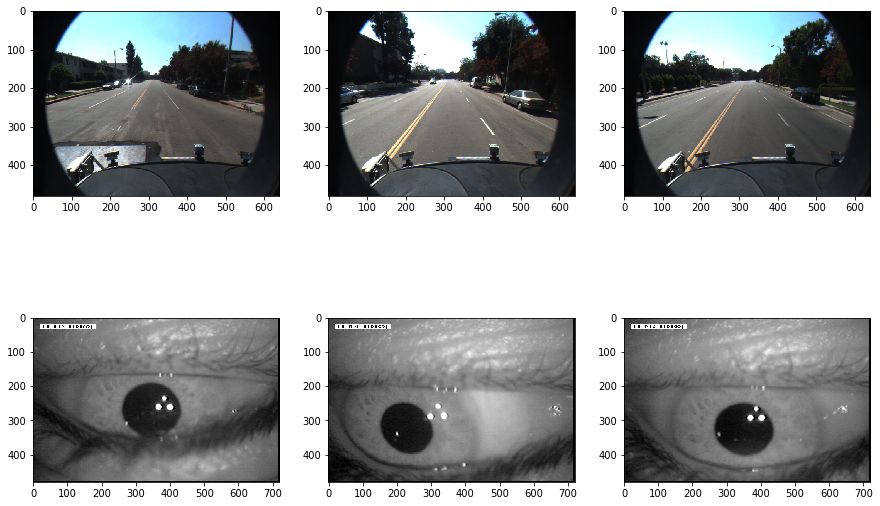

In [9]:
%matplotlib inline 
import matplotlib.pyplot as plt
from skimage import io, data, feature, color
import os
import numpy as np
import cv2

from tqdm import tqdm
from google.colab import drive
drive.mount('/content/gdrive')

notebooks_path = "./gdrive/My Drive/Colab Notebooks"
root_path = os.path.join(notebooks_path, "Computer Vision")

lane1 = io.imread(os.path.join(root_path, 'images/lane_detection/f00000.png'))
lane2 = io.imread(os.path.join(root_path, 'images/lane_detection/f00050.png'))
lane3 = io.imread(os.path.join(root_path, 'images/lane_detection/f00090.png'))

eye1 = io.imread(os.path.join(root_path, 'images/eye_tracking/0000.jpeg'))
eye2 = io.imread(os.path.join(root_path, 'images/eye_tracking/0050.jpeg'))
eye3 = io.imread(os.path.join(root_path, 'images/eye_tracking/0090.jpeg'))

fig = plt.figure(figsize=(15, 10))
ax11 = plt.subplot(2, 3, 1)
ax12 = plt.subplot(2, 3, 2)
ax13 = plt.subplot(2, 3, 3)
ax21 = plt.subplot(2, 3, 4)
ax22 = plt.subplot(2, 3, 5)
ax23 = plt.subplot(2, 3, 6)



ax11.imshow(lane1)
ax12.imshow(lane2)
ax13.imshow(lane3)

ax21.imshow(eye1)
ax22.imshow(eye2)
ax23.imshow(eye3)

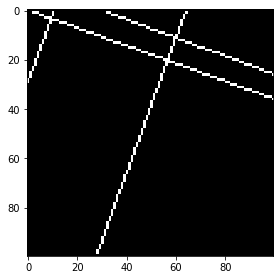

In [10]:
# dieser Code wurde als Musterlösung von Sebastian Oltmanns zur Verfügung gestellt und von Tim renoviert

%matplotlib inline
from skimage.draw import line
from skimage import io
import math
import numpy as np

def draw_line_hessian_normal(image, a, r):
    
    (dimy,dimx) = image.shape

    #r = x*cosa + y*sina

    # compute start and end point of line 
    x0 = 0
    y0 = int(round((r - x0*math.cos(math.radians(a)))/math.sin(math.radians(a))))
    x1 = dimx
    y1 = int(round((r - x1*math.cos(math.radians(a)))/math.sin(math.radians(a))))

    liney,linex = line(y0,x0,y1,x1)
    
    ret = np.copy(image)
    for yy in range(0,liney.size-1):
        if (liney[yy] > 0) and (liney[yy] < dimy-1):
            ret[liney[yy],linex[yy]] = 1
    return ret

image = np.zeros((100,100))
image = draw_line_hessian_normal(image, 20, 60)
image = draw_line_hessian_normal(image, 20, 10)
image = draw_line_hessian_normal(image, 110, 0)
image = draw_line_hessian_normal(image, -70, 10)
io.imshow(image)

## OPTION 1: line detection for lane detection 

* use your implementation of the Hough Transform to find the 10 strongest lines in the image
* display your result set (draw those lines on the image) (**RESULT**)
* can you improve the performance by limiting the space of solutions? implement and draw lines again! (**BONUS**)

Since we already implemeted Canny edge detection in the 2nd exercise sheet, in this exercise sheet simply use the function provided by the OpenCV library:

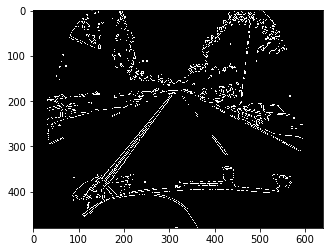

In [3]:
edges_lane2 = cv2.Canny(lane2, 100, 200)
plt.imshow(edges_lane2, cmap="gray")

In [0]:
def hough_trafo_line(image, steps=100, k=None):
  """
    For an edge detection image, returns the hough transform detecting lines.
    Expects: 
    - image (numpy.array): An image of shape width x height with pixel values 0 or 1
    - steps (int): An integer specifying the number of bins to use for parameter scanning
    - k (int): If not None, function will return the coordinates of the top values
  """
  assert len(image.shape) == 2
  height, width = image.shape
  radius = np.ceil(np.sqrt(height**2 + width**2))
  angle_space, theta_step = np.linspace(0, 180, steps, retstep=True)
  r_space, r_step = np.linspace(0, radius, steps, retstep=True)
  A = np.zeros([steps, steps])

  for x in range(width):
    for y in range(height):
      if(image[y,x]):
        r = x * np.cos(np.radians(angle_space)) + y * np.sin(np.radians(angle_space))
        theta_bins, r_bins = np.round(angle_space / theta_step).astype(int), np.round(r / r_step).astype(int)
        A[theta_bins, r_bins] += 1
  if k:
    sorted_bins_theta, sorted_bins_r = np.unravel_index(np.argsort(A.ravel(), kind="heapsort"), [steps, steps])
    topk_theta, topk_r = angle_space[sorted_bins_theta[-k:]], r_space[sorted_bins_r[-k:]]
    return A, list(zip(topk_theta, topk_r))
  else:
    return A

def hough_trafo_topk(image, A, k):
  """
    Given an original grayscale image and an accumulator A, returns the top k line detections.
    Expects:
    - image (numpy.array): An image of shape width x height with pixel values 0 or 1
    - A (numpy.array): An accumulator of shape steps x steps, dtype int
    - k (int): Specifies the number of top detections to return
  """
  assert len(image.shape) == 2
  height, width = image.shape
  assert len(A.shape) == 2 and A.shape[0] == A.shape[1]
  steps = A.shape[0]

  radius = np.ceil(np.sqrt(height**2 + width**2))
  angle_space, theta_step = np.linspace(0, 180, steps, retstep=True)
  r_space, r_step = np.linspace(0, radius, steps, retstep=True)

  sorted_bins_theta, sorted_bins_r = np.unravel_index(np.argsort(A.ravel(), kind="heapsort"), [steps, steps])
  topk_theta, topk_r = angle_space[sorted_bins_theta[-k:]], r_space[sorted_bins_r[-k:]]
  return list(zip(topk_theta, topk_r))

In [0]:
trafo_lane2 = hough_trafo_line(edges_lane2, 200)

We visualize not the top 10 line detections, but the top 20 line detections in order to visualize the street outlines given our step granularity:

In [0]:
top20 = hough_trafo_topk(edges_lane2, trafo_lane2, 20)

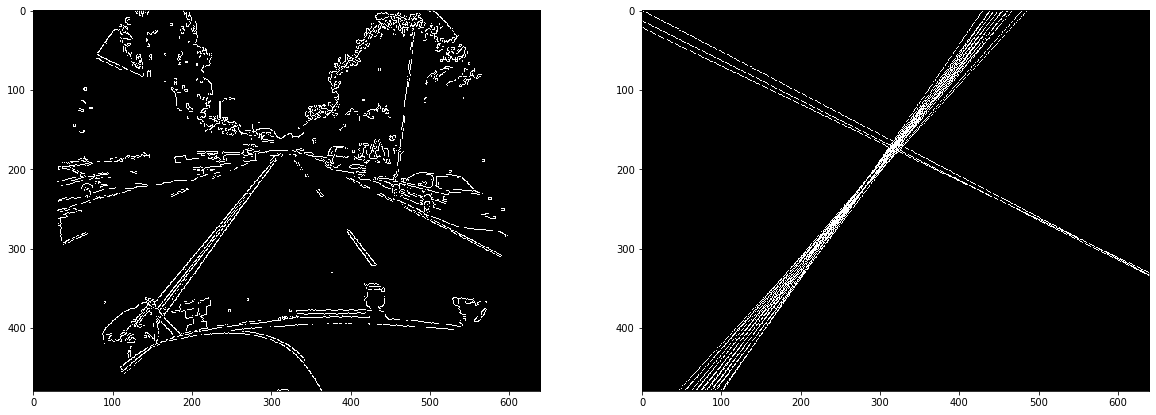

In [7]:
image_ = np.zeros(edges_lane2.shape, dtype=int)
for a, r in top20:
  image_ = draw_line_hessian_normal(image_, a, r)

fix, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(edges_lane2, cmap="gray")
ax[1].imshow(image_, cmap="gray")

## OPTION 2: circle detection for eye detection
* use your implementation of the Hough Transform to find the 10 strongest circles in the image
* display your result set (draw those circles on the image) (**RESULT**)
* can you improve the performance by limiting the space of solutions? implement and draw circles again! (**BONUS**)

# Ex. 4.2 Generalized Hough Transform

* implement the Generalized Hough Transform as described in the lecture for localizing a given template
* find the given template (see below) and mark its location in the image "animals.png" (**RESULT**)

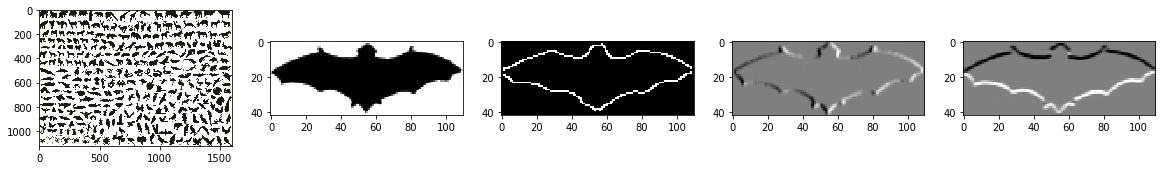

In [11]:
%matplotlib inline 
import matplotlib.pyplot as plt
from skimage import io, data, feature, color
import numpy as np

animals_rgb = io.imread(os.path.join(root_path, 'images/animals.png'))

xmin = 1271
xmax = 1381
ymin = 519
ymax = 561

bat = animals_rgb[ymin:ymax, xmin:xmax]
bat = cv2.cvtColor(bat, cv2.COLOR_RGB2GRAY)
bat_edge = feature.canny(bat / 255., 2)
bat_sobelx = cv2.Sobel(bat, cv2.CV_64F, 1, 0,ksize=3)
bat_sobely = cv2.Sobel(bat, cv2.CV_64F, 0, 1,ksize=3)

fig, ax = plt.subplots(1, 5, figsize=(20, 10))
ax[0].imshow(animals_rgb)
ax[1].imshow(bat, cmap="gray")
ax[2].imshow(bat_edge, cmap="gray")
ax[3].imshow(bat_sobelx, cmap="gray")
ax[4].imshow(bat_sobely, cmap="gray")
plt.show()

Let us make sure the edge detection not only works on the bat image, but also on the entire image (since we will be needing that for the shape search):

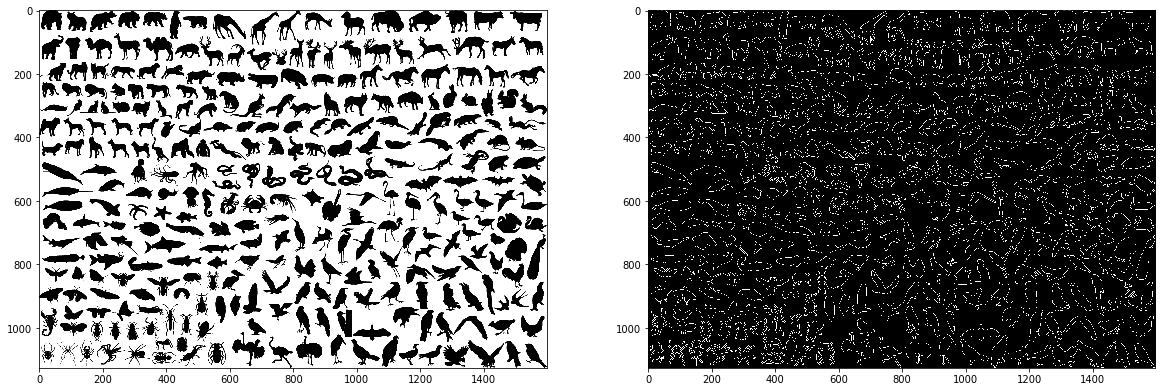

In [12]:
animals = cv2.cvtColor(np.copy(animals_rgb), cv2.COLOR_RGB2GRAY)
animals_edge = feature.canny(animals / 255., 2)

fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(animals, cmap="gray")
ax[1].imshow(animals_edge, cmap="gray")

In [0]:
def get_com(image):
  y, x = np.where(image)
  y_center = np.round(np.sum(y) / len(y)).astype(int)
  x_center = np.round(np.sum(x) / len(x)).astype(int)
  return y_center, x_center

def hough_trafo_preprocess(image, c, steps=100):
  """
  Expects:
  - c (tuple): Reference center
  """
  assert len(image.shape) == 2
  height, width = image.shape
  assert len(c) == 2
  cy, cx = c

  image_edge = feature.canny(image / 255., 2)
  Gx = cv2.Sobel(image, cv2.CV_64F, 1, 0,ksize=3)
  Gy = cv2.Sobel(image, cv2.CV_64F, 0, 1,ksize=3)
  G_theta = np.arctan2(Gx, Gy) + np.pi
  theta_space, theta_step = np.linspace(0, 2 * np.pi, steps, retstep=True)

  Rx = [np.array([], dtype=int) for _ in range(steps)]
  Ry = [np.array([], dtype=int) for _ in range(steps)]

  for x in range(width):
    for y in range(height):
      if(image_edge[y,x]):
        ry, rx = cy - y, cx - x
        theta_bin = np.round(G_theta[y,x] / theta_step).astype(int)
        Ry[theta_bin] = np.append(Ry[theta_bin], ry)
        Rx[theta_bin] = np.append(Rx[theta_bin], rx)

  return Ry, Rx

def hough_trafo_gen(image, R, k=None):
  assert len(image.shape) == 2
  height, width = image.shape
  assert len(R) == 2
  Ry, Rx = R
  assert len(Ry) == len(Rx)
  steps = len(Ry)

  image_edge = feature.canny(image / 255., 2)
  Gx = cv2.Sobel(image, cv2.CV_64F, 1, 0,ksize=3)
  Gy = cv2.Sobel(image, cv2.CV_64F, 0, 1,ksize=3)
  G_theta = np.arctan2(Gx, Gy) + np.pi
  theta_space, theta_step = np.linspace(0, 2 * np.pi, steps, retstep=True)

  A = np.zeros(image.shape)
  for x in range(width):
    for y in range(height):
      if(image_edge[y,x]):
        theta_bin = np.round(G_theta[y,x] / theta_step).astype(int)
        y_, x_ = np.minimum(y + Ry[theta_bin], height-1), np.minimum(x + Rx[theta_bin], width-1)
        if len(y_) > 0 and len(x_) > 0:
          A[y_, x_] += 1
  if k:
    sorted_y, sorted_x = np.unravel_index(np.argsort(A.ravel(), kind="heapsort"), image.shape)
    topk_y, topk_x = sorted_y[-k:], sorted_x[-k:]
    if k == 1:
      return A, (topk_y, topk_x)
    else:
      return A, list(zip(topk_y, topk_x))

  else:
    return A

We select the center of mass as reference point for the generation of the R table in the preprocessing of the shape. Then, using the R table, we identify the pixel of the original image with maximum counts and center a bounding box the size of the shape centered around it. As we can see, the bat is correctly identified. 

In [0]:
R = hough_trafo_preprocess(bat, get_com(bat), 200)

In [0]:
A, center = hough_trafo_gen(animals, R, 1)

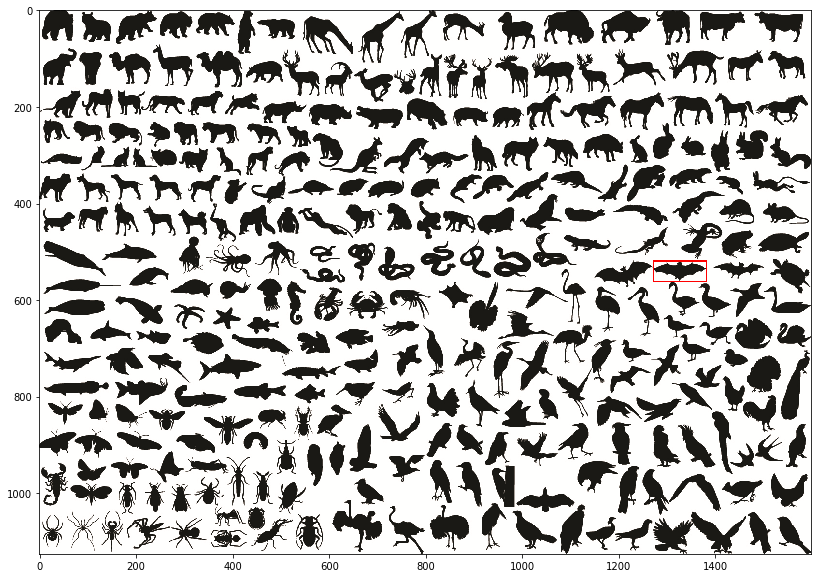

In [16]:
com = get_com(bat)
ymin, xmin = center[0] - com[0], center[1] - com[1]
ymax, xmax = ymin + bat.shape[0], xmin + bat.shape[1]
bat_in_animals = cv2.rectangle(np.copy(animals_rgb), (xmin, ymin), (xmax, ymax), (255,0,0), 2)
fig, ax = plt.subplots(1, figsize=(20, 10))
ax.imshow(bat_in_animals)

## BONUS 
* now implement an extended version of the GHT that find rotated and scaled variants of the template. 
* find Italy (see "italy.jpg") and the map of Europe ("europe_map_political.gif")
* note that you can binarize your italy template by using a simple color lookup
* draw the location of italy on the map and print its scale and orientation (**BONUS**)

Although we tried implementing the hough transform with scaling, we were not able to get the right result using a scaled bat. We also tried a more naive implementation without numpy optimizations, but the calculation times are prohibitive.

In [0]:
def hough_trafo_gen_extended(image, shape, steps=100, k=None):
  assert len(image.shape) == 2
  height, width = image.shape
  assert len(shape.shape) == 2
  shape_height, shape_width = shape.shape
  Ry, Rx = hough_trafo_preprocess(shape, get_com(shape), steps)
  
  # We assume that any shape smaller than 10 x 10 cannot be meaningfully distinguished from other shapes
  min_scale = max(10 / shape_height, 10 / shape_width)
  # Furthermore, we assume that any scale s.t. the search shape cannot be encompassed by the target image makes no sense
  max_scale = min(height / shape_height, width / shape_width)

  image_edge = feature.canny(image / 255., 2)
  Gx = cv2.Sobel(image, cv2.CV_64F, 1, 0,ksize=3)
  Gy = cv2.Sobel(image, cv2.CV_64F, 0, 1,ksize=3)
  G_theta = np.arctan2(Gx, Gy) + np.pi

  theta_space, theta_step = np.linspace(0, 2 * np.pi, steps, retstep=True)
  scale_space, scale_step = np.linspace(min_scale, max_scale, steps, retstep=True)
  steps_ = len(scale_space)
  print(scale_space)

  A = np.zeros([height, width, steps_])
  for theta_bin in range(steps):
    Ry[theta_bin] = np.outer(scale_space, Ry[theta_bin])
    Rx[theta_bin] = np.outer(scale_space, Rx[theta_bin])

  for x in range(width):
    for y in range(height):
      if(image_edge[y,x]):
        theta_bin = np.round(G_theta[y,x] / theta_step).astype(int)
        y_ = np.round(y + Ry[theta_bin]).astype(int)
        x_ = np.round(x + Rx[theta_bin]).astype(int)
        idx = np.where(np.logical_and(y_.flatten() < height - 1, x_.flatten() < width -1 ))  
        y_, x_ = y_.flatten()[idx], x_.flatten()[idx]
        if len(y_) > 0 and len(x_) > 0:
          s = np.repeat(np.arange(steps_), Ry[theta_bin].shape[1])[idx]
          A[y_, x_, s] += 1
        
  if k:
    sorted_y, sorted_x, sorted_scale = np.unravel_index(np.argsort(A.ravel(), kind="heapsort"), A.shape)
    topk_y, topk_x, topk_scale = sorted_y[-k:], sorted_x[-k:], scale_space[sorted_scale[-k:]]
    if k == 1:
      return A, (topk_y, topk_x, topk_scale)
    else:
      return A, list(zip(topk_y, topk_x, topk_scale))

  else:
    return A

In [0]:
bat_large = cv2.resize(np.copy(bat), (2 * bat.shape[1], 2 * bat.shape[0]))

In [54]:
A, top = hough_trafo_gen_extended(animals, bat_large, steps=50, k=10)

[0.11904762 0.26485555 0.41066349 0.55647142 0.70227935 0.84808729
 0.99389522 1.13970315 1.28551109 1.43131902 1.57712695 1.72293489
 1.86874282 2.01455076 2.16035869 2.30616662 2.45197456 2.59778249
 2.74359042 2.88939836 3.03520629 3.18101422 3.32682216 3.47263009
 3.61843802 3.76424596 3.91005389 4.05586183 4.20166976 4.34747769
 4.49328563 4.63909356 4.78490149 4.93070943 5.07651736 5.22232529
 5.36813323 5.51394116 5.65974909 5.80555703 5.95136496 6.0971729
 6.24298083 6.38878876 6.5345967  6.68040463 6.82621256 6.9720205
 7.11782843 7.26363636]


In [55]:
top

[(795, 172, 0.8480872868627971),
 (540, 1321, 0.5564714197367259),
 (43, 499, 0.9938952204258328),
 (627, 131, 0.9938952204258328),
 (542, 1328, 0.5564714197367259),
 (628, 133, 0.9938952204258328),
 (904, 111, 0.9938952204258328),
 (904, 110, 0.9938952204258328),
 (541, 1321, 0.5564714197367259),
 (540, 1320, 0.5564714197367259)]

In [8]:
np.repeat(np.arange(5), 2)

array([0, 0, 1, 1, 2, 2, 3, 3, 4, 4])

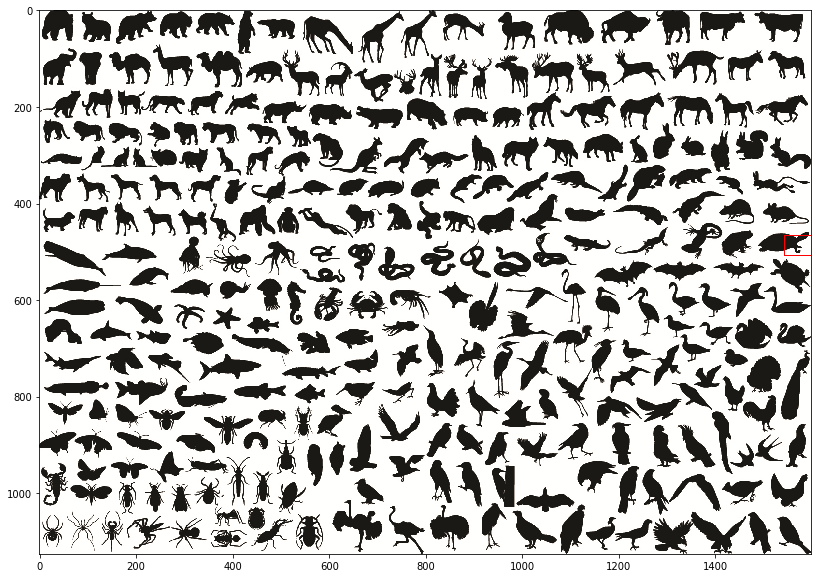

In [49]:
com = get_com(bat)
center = top[1]
ymin, xmin = center[0] - com[0], center[1] - com[1]
ymax, xmax = ymin + bat.shape[0], xmin + bat.shape[1]
bat_in_animals = cv2.rectangle(np.copy(animals_rgb), (xmin, ymin), (xmax, ymax), (255,0,0), 2)
fig, ax = plt.subplots(1, figsize=(20, 10))
ax.imshow(bat_in_animals)